### Introduction

This Jupyter Notebook is dedicated to building a predictive model for movie success. By combining data on movie metadata, character details, and enriched information from TMDb, our goal is to create a robust predictor that can estimate a movie's success based on various factors like genre, actor collaborations, and character traits. This analysis will lay the groundwork for understanding what makes a movie successful, helping to uncover the key elements that contribute to box office performance and critical acclaim. Through data merging, cleaning, and advanced modeling, this Notebook aims to provide valuable insights into the factors driving cinematic success.


This cell imports the necessary libraries and modules that are used throughout the Notebook for data processing, visualization, and machine learning tasks. The key libraries include:

- **pandas and numpy**: Used for data manipulation and numerical operations.
- **matplotlib and seaborn**: Used for creating plots and visualizations.
- **xgboost**: Provides powerful gradient boosting algorithms for building predictive models.
- **sklearn**: Includes tools for data preprocessing, model evaluation, and splitting datasets into training and testing sets.
- **scipy.stats**: Used for statistical operations, such as generating distributions for hyperparameter tuning.

This extensive list of imports suggests a comprehensive data science workflow that covers data handling, model building, and visualization.

In [2]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
import re
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
# Import all helper functions
import sys
sys.path.append("..")
from helpers_regression import (
    load_tsv_data,
    load_excel_data,
    filter_by_date,
    filter_by_value,
    drop_missing_threshold,
    fill_missing_median,
    clean_column_strings,
    one_hot_encode_multilabel,
    convert_to_binary,
    select_numeric,
    remove_zero_variance,
    remove_constant_columns,
    remove_outliers_iqr,
    scale_features,
    train_test_split_data,
    run_random_search,
    evaluate_model,
    cross_validate_model,
    save_model_and_scaler,
    plot_predicted_vs_actual,
    plot_residuals,
    plot_residual_distribution,
    plot_qq,
    remove_invalid_chars,
)


In [3]:
ABS_PATH = '/Users/mohamedhedihidri/Desktop/ada-2024-project-theundocumentedanalysts/data'

### Loading Movie and Character Metadata

This cell loads two datasets containing movie metadata and character information using Pandas. The `movie_metadata` dataset provides details about movies such as their IDs, names, release dates, box office revenue, runtime, languages, countries, and genres. The `character_metadata` dataset focuses on character-level details, including names, associated movies, actors' personal information, and unique identifiers.

In [4]:
movie_metadata = load_tsv_data(
    filepath=ABS_PATH+'/MovieSummaries/movie.metadata.tsv',
    col_names=[
        'wikipedia_movie_id', 
        'freebase_movie_id', 
        'movie_name', 
        'movie_release_date', 
        'movie_box_office_revenue', 
        'movie_runtime', 
        'movie_languages', 
        'movie_countries', 
        'movie_genres'
    ]
)

character_metadata = load_tsv_data(
    filepath=ABS_PATH+'/MovieSummaries/character.metadata.tsv',
    col_names=[
        'wikipedia_movie_id',
        'freebase_movie_id',
        'movie_release_date',
        'character_name',
        'actor_date_of_birth',
        'actor_gender',
        'actor_height',
        'actor_ethnicity',
        'actor_name',
        'actor_age_at_movie_release',
        'freebase_character_actor_map_id',
        'freebase_character_id',
        'freebase_actor_id'
    ]
)


### Merging Character and Movie Metadata

This cell merges the `character_metadata` and `movie_metadata` DataFrames on the common column `wikipedia_movie_id` using an inner join. This operation creates a new dataset, `merged_movie_character`, which combines information about both movies and their associated characters. The inner join ensures that only rows with matching `wikipedia_movie_id` values in both DataFrames are retained.

In [5]:
merged_movie_character = pd.merge(character_metadata, movie_metadata, 
                                  left_on='wikipedia_movie_id', 
                                  right_on='wikipedia_movie_id', 
                                  how='inner')

### Dropping Unnecessary Columns

In this cell, several columns are dropped from the `merged_movie_character` DataFrame, including `freebase_character_actor_map_id`, `freebase_character_id`, `freebase_actor_id`, `freebase_movie_id_x`, and `freebase_movie_id_y`. These columns contain identifiers that are not relevant for further analysis. 

In [6]:

#remove the columns freebase_character_actor_map_id freebase_character_id freebase_actor_id  freebase_movie_id_y

merged_movie_character = merged_movie_character.drop(['freebase_character_actor_map_id',
                                                                'freebase_character_id',
                                                                'freebase_actor_id',
                                                                'freebase_movie_id_x',
                                                                'freebase_movie_id_y'], axis=1)


### Loading and Cleaning TMDb Dataset

This cell loads data from a TMDb dataset stored in an Excel file. After loading the data, it applies several preprocessing steps:

1. **Filtering**: The dataset is filtered to retain only movies with a release date on or before `2014-03-28`.

2. **Column Removal**: Various columns such as `ID`, `FILMID`, `BACKDROP_PATH`, `HOMEPAGE`, `IMDB_ID`, `POSTER_PATH`, `ORIGINAL_LANGUAGE`, `ORIGINAL_TITLE`, `OVERVIEW`, `STATUS_`, and `COLLECTIONID` are removed. This step reduces unnecessary data, focusing on relevant attributes.

3. **Merging with Character Data**: The cleaned TMDb dataset is then merged with the `merged_movie_character` DataFrame on the `movie_name` (from `merged_movie_character`) and `TITLE` (from the TMDb dataset) columns using an inner join. This creates a new dataset, `merged_movie_character_tmdb`, which combines movie-specific data from TMDb with previously merged character and movie metadata.


In [7]:
#load tmdb dataset (xlsx file)
tmdb = pd.read_excel(ABS_PATH+'/TMDB_dataset/MOVIE.xlsx')

#remove values where release date is after 2014-03-28
tmdb = tmdb[tmdb['RELEASE_DATE'] <= '2014-03-28']
#remove column ID, FILMID, BACKDROP_PATH, HOMEPAGE, IMDB_ID, ORIGINAL_LANGUAGE, ORIGINAL_TITLE, OVERVIEW,STATUS ,COLLECTIONID,POSTER_PATH
tmdb = tmdb.drop(['ID', 'FILMID', 'BACKDROP_PATH', 'HOMEPAGE', 'IMDB_ID','POSTER_PATH', 'ORIGINAL_LANGUAGE', 'ORIGINAL_TITLE', 'OVERVIEW', 'STATUS_', 'COLLECTIONID'], axis=1)
#join the tmdb dataset with the merged_movie_character_plot dataset on the movie_name column
merged_movie_character_tmdb = pd.merge(merged_movie_character, tmdb, 
                                            left_on='movie_name', 
                                            right_on='TITLE', 
                                            how='inner')


### Handling Missing Budget and Dropping Irrelevant Columns

This cell performs several data cleaning tasks on the `merged_movie_character_tmdb` DataFrame:


1. **Dropping Irrelevant Columns**: It removes the `actor_date_of_birth`, `REVENUE` (since `movie_box_office_revenue` is already present), `TAGLINE`, and `TITLE` columns to streamline the dataset by retaining only necessary features.

2. **Handling Missing Values in Budget**: Rows with missing values and 0s in the `BUDGET` column are dropped to ensure all entries have valid budget data.



In [8]:
#remove actor_date_of_birth, revenue column (since we already have box office revenue),tagline and title
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['actor_date_of_birth','REVENUE','TAGLINE','TITLE'], axis=1)
#remove values where budget is NaN or 0
merged_movie_character_tmdb = merged_movie_character_tmdb[merged_movie_character_tmdb['BUDGET'] > 0]

### Dropping Columns with High Missing Values

This cell removes columns with more than 40% missing values from the `merged_movie_character_tmdb` DataFrame, ensuring that only features with sufficient data are retained for analysis. This step reduces noise and improves data quality.

In [9]:
#remove column with more than 40% missing values
merged_movie_character_tmdb = merged_movie_character_tmdb.dropna(thresh=0.6*len(merged_movie_character_tmdb), axis=1)


### Filling Missing Numeric Values

This cell fills missing values in numeric columns with their median values, ensuring data consistency and robustness against outliers.

In [10]:
#fill missing values in each column with numerical values with the median value of that column
for column in merged_movie_character_tmdb.select_dtypes(include=['float64', 'int64']).columns:
    merged_movie_character_tmdb[column].fillna(merged_movie_character_tmdb[column].median(), inplace=True)


/var/folders/xk/1t18v00n18v8q2_llcf4wrd80000gn/T/ipykernel_79601/2781533621.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_movie_character_tmdb[column].fillna(merged_movie_character_tmdb[column].median(), inplace=True)


### One-Hot Encoding for Actors with Frequent Appearances

This cell counts the number of distinct movies each actor appears in and creates one-hot encoded dummy variables for actors who appear in at least five different movies. This transformation enables the model to capture the influence of frequently appearing actors in the dataset, enhancing feature richness.

In [11]:
# Count the appearances of each actor
actor_movie_counts = merged_movie_character_tmdb.groupby('actor_name')['movie_name'].nunique()

# Filter actors who appear at least 5 times
actors_with_10_or_more_movies = actor_movie_counts[actor_movie_counts >= 5].index

# Add dummy columns directly to the DataFrame
for actor in actors_with_10_or_more_movies:
    col_name = f'dummy_actor_{actor}'
    merged_movie_character_tmdb[col_name] = (merged_movie_character_tmdb['actor_name'] == actor).astype(int)


/var/folders/xk/1t18v00n18v8q2_llcf4wrd80000gn/T/ipykernel_79601/3741776963.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_movie_character_tmdb[col_name] = (merged_movie_character_tmdb['actor_name'] == actor).astype(int)
/var/folders/xk/1t18v00n18v8q2_llcf4wrd80000gn/T/ipykernel_79601/3741776963.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_movie_character_tmdb[col_name] = (merged_movie_character_tmdb['actor_name'] == actor).astype(int)
/var/folders/xk/1t18v00n18v8q2_llcf4wrd80000gn/T/ipykernel_79601/3

### Cleaning and One-Hot Encoding Categorical Columns

This cell performs several tasks:

1. **Genre Extraction and Encoding**: Cleans and extracts genre names from the `movie_genres` column, then uses one-hot encoding to create binary features for each genre.
2. **Language and Country Encoding**: Cleans and extracts languages and countries from the respective columns and applies one-hot encoding to these features as well.
3. **Column Removal**: Drops original columns like `movie_genres`, `genre_list`, `movie_languages`, `movie_countries`, `actor_name`, and `character_name` to avoid redundancy.

This step converts categorical data into a numeric format suitable for modeling while enriching the dataset with meaningful features.

In [12]:
# Clean the genre column and one-hot encode
merged_movie_character_tmdb['genre_list'] = merged_movie_character_tmdb['movie_genres'].apply(clean_column_strings)
genre_dummies = one_hot_encode_multilabel(merged_movie_character_tmdb, 'genre_list', min_count=20)
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, genre_dummies], axis=1)

# Clean the languages column and one-hot encode
merged_movie_character_tmdb['movie_languages'] = merged_movie_character_tmdb['movie_languages'].apply(clean_column_strings)
lang_dummies = one_hot_encode_multilabel(merged_movie_character_tmdb, 'movie_languages', min_count=20)
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, lang_dummies], axis=1)

# Clean the countries column and one-hot encode
merged_movie_character_tmdb['movie_countries'] = merged_movie_character_tmdb['movie_countries'].apply(clean_column_strings)
country_dummies = one_hot_encode_multilabel(merged_movie_character_tmdb, 'movie_countries', min_count=20)
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, country_dummies], axis=1)

# Drop unused columns
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(
    ['movie_genres', 'genre_list', 'movie_languages', 'movie_countries', 'actor_name', 'character_name'], 
    axis=1
)


/var/folders/xk/1t18v00n18v8q2_llcf4wrd80000gn/T/ipykernel_79601/1145182122.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_movie_character_tmdb['genre_list'] = merged_movie_character_tmdb['movie_genres'].apply(clean_column_strings)


### Converting Release Date and Dropping Redundant Column

This cell converts the `movie_release_date_x` column to a datetime format and extracts the year from it. It then drops the `movie_release_date_y` column, which may be redundant after merging. This step ensures consistent date formatting and focuses on extracting relevant date-related information for further analysis.

In [13]:
# Convert the release date to datetime, coercing errors to NaT
merged_movie_character_tmdb['movie_release_date_x'] = pd.to_datetime(
    merged_movie_character_tmdb['movie_release_date_x'], errors='coerce'
)

# Extract the year from the release date
merged_movie_character_tmdb['movie_release_date_x'] = merged_movie_character_tmdb['movie_release_date_x'].dt.year

#drop column movie_release_date_y
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['movie_release_date_y'], axis=1)


### Removing Rows with Missing Values and Filtering by Vote Count

This cell performs two key data cleaning operations:

1. **Removing Rows with Missing Values**: Drops rows that contain any missing values to ensure data completeness.
2. **Filtering by Vote Count**: Retains only rows where `VOTE_COUNT` is greater than or equal to 5, focusing the analysis on movies with a minimum level of engagement.



In [14]:
#remove values that have nans
merged_movie_character_tmdb = merged_movie_character_tmdb.dropna()
#remove values that have a vote count less than 5
merged_movie_character_tmdb = merged_movie_character_tmdb[merged_movie_character_tmdb['VOTE_COUNT'] >= 5]


### Dropping Specific Columns and Duplicates

This cell removes the `actor_gender`, and `actor_age_at_movie_release` columns from the `merged_movie_character_tmdb` DataFrame. It also ensures that only one entry per `movie_name` is retained by dropping duplicate entries based on this column. 

In [15]:
# Remove columns actor_gender,  actor_age_at_movie_release
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(columns=['actor_gender','actor_age_at_movie_release'])
# only keep one value per  'movie_name'
merged_movie_character_tmdb = merged_movie_character_tmdb.drop_duplicates(subset=['movie_name'])


In [16]:
#remove column RELEASE_DATE and movie_name
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['RELEASE_DATE'], axis=1)
movie_name_column = merged_movie_character_tmdb['movie_name']
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['movie_name'], axis=1)

### Converting `ADULT` Column to Binary

This cell transforms the `ADULT` column in the `merged_movie_character_tmdb` DataFrame into a binary format. It converts values to `1` if the movie is marked as adult (`True`) and `0` otherwise. 

In [17]:
#make ADULT column binary instead true and false
merged_movie_character_tmdb['ADULT'] = merged_movie_character_tmdb['ADULT'].apply(lambda x: 1 if x == True else 0)


### Removing Columns with Zero Variance

This cell removes columns from the `merged_movie_character_tmdb` DataFrame that have zero variance. Columns with zero variance contain the same value for all observations and therefore do not contribute any useful information for modeling or analysis. 

In [18]:
#removie columns with 0 variance
merged_movie_character_tmdb = merged_movie_character_tmdb.loc[:, merged_movie_character_tmdb.var() != 0]
# copy the dataframe for later use
df_countries_genres = merged_movie_character_tmdb.copy()


### Data Preprocessing, Outlier Removal, Feature Scaling, and Model Training

This cell performs an end-to-end pipeline, including data preprocessing, outlier removal, feature scaling, and model training:

1. **Initial Data Copy**: A copy of the `merged_movie_character_tmdb` DataFrame is made to preserve the original data.

2. **Non-Scalar Value Handling**: Columns containing non-scalar values are identified and removed to ensure data compatibility for modeling.

3. **Numeric Data Selection and Missing Value Handling**: Only numeric columns are retained, and missing values are filled with their column mean.

4. **Outlier Removal**: Outliers in the `VOTE_AVERAGE` column are removed using the IQR method with a threshold of 1.5, focusing the data on central values.

5. **Feature and Target Separation**: The features (`X`) and target (`y`) are separated, with further cleaning to ensure no missing values in `y`.

6. **Feature Scaling**: Features are standardized using `StandardScaler` to ensure consistent input for modeling.

7. **Train-Test Split**: The data is split into training and testing sets to facilitate model evaluation.

8. **Model Training with XGBoost**: An `XGBRegressor` is set up with hyperparameter tuning using `RandomizedSearchCV` and 5-fold cross-validation to optimize performance.

9. **Model Evaluation**: The best model is evaluated on the test set using mean absolute error (MAE) and mean absolute percentage error (MAPE).

10. **Cross-Validation**: Additional 5-fold cross-validation on the best model is conducted to assess its robustness and performance consistency across folds.



In [31]:
df = merged_movie_character_tmdb.copy()

# Identify and remove non-scalar columns
non_scalar_columns = [col for col in df.columns if not all(np.isscalar(val) for val in df[col].dropna())]
if non_scalar_columns:
    df = df.drop(non_scalar_columns, axis=1, errors='ignore')

# Ensure all features are numeric by selecting numeric columns
df = df.select_dtypes(include=[np.number])

# Fill missing values with mean for numeric columns
df = df.fillna(df.mean())

# Remove outliers using IQR method (helper)
df = remove_outliers_iqr(df, target_col='VOTE_AVERAGE', threshold=1.5)

# Separate features and target
if 'VOTE_AVERAGE' not in df.columns:
    raise ValueError("VOTE_AVERAGE column missing after preprocessing.")

X = df.drop('VOTE_AVERAGE', axis=1)
y = df['VOTE_AVERAGE']

# Convert all X columns to numeric, coercing errors to NaN if any remain
X = X.apply(pd.to_numeric, errors='coerce')

# Remove invalid characters using the helper function
invalid_chars = ['[', ']', '<', '>']
X.columns = X.columns.map(str)
X = remove_invalid_chars(X, invalid_chars)

# Drop rows where target (y) is NaN
valid_indices = y.notnull() & X.notnull().all(axis=1)
X = X.loc[valid_indices]
y = y.loc[valid_indices]

# Ensure no duplicated columns
if X.columns.duplicated().any():
    X = X.loc[:, ~X.columns.duplicated()]

# Scale features using helper
X, scaler = scale_features(X)

# Train-test split using helper
X_train, X_test, y_train, y_test = train_test_split_data(X, y, test_size=0.2, random_state=42)

# Ensure proper alignment of X_test and y_test after splitting
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Define parameter distributions for random search
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Run random search using helper
best_xgb, best_params = run_random_search(X_train, y_train, param_distributions,
                                          n_iter=50, cv=5, random_state=42, n_jobs=-1)

# Evaluate model using helper
mae, mape, y_pred = evaluate_model(best_xgb, X_test, y_test)

# Ensure y_pred is properly aligned
y_pred = pd.Series(y_pred, index=y_test.index)

print(f"Mean Absolute Error on test data: {mae:.4f}")
print(f"Mean Absolute Percentage Error on test data: {mape:.4f}")

# Print best hyperparameters
print("\nBest hyperparameters found:")
for param_name, value in best_params.items():
    print(f"{param_name}: {value}")

# Cross-validate the model using helper
mean_cv_mae, std_cv_mae, cv_scores = cross_validate_model(best_xgb, X_train, y_train, cv=5, random_state=42)
print(f"\nMean CV MAE: {mean_cv_mae:.4f} ± {std_cv_mae:.4f}")
print("Cross-validation MAE scores for each fold:", cv_scores)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mean Absolute Error on test data: 0.4210
Mean Absolute Percentage Error on test data: 0.0705

Best hyperparameters found:
colsample_bytree: 0.8075162486973464
gamma: 0.3515094794475889
learning_rate: 0.08272592047585879
max_depth: 3
n_estimators: 541
reg_alpha: 0.9624472949421112
reg_lambda: 0.25178229582536416
subsample: 0.7988994023569542


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.6s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished



Mean CV MAE: 0.4193 ± 0.0108
Cross-validation MAE scores for each fold: [0.42088586 0.41089365 0.43369501 0.40376325 0.42733148]


### Model Performance Summary and Interpretation

#### Model Evaluation Metrics:
- **Mean Absolute Error (MAE) on Test Data**: 0.4210  
  On average, the model's predictions differ from the actual `VOTE_AVERAGE` values by approximately 0.4210. While this is a reasonably low error, it still leaves room for further improvements through fine-tuning and feature engineering.

- **Mean Absolute Percentage Error (MAPE) on Test Data**: 0.0705 (or 7.05%)  
  The model's predictions are, on average, about 7.05% off from the actual values. A lower MAPE would be ideal, but this score indicates that the model is providing predictions that are fairly close relative to the scale of the target variable.

#### Hyperparameter Tuning Results:
- **Optimal Hyperparameters**:
  - `colsample_bytree`: 0.8075  
    Controls the fraction of features (columns) randomly sampled for each tree, helping reduce overfitting.
  - `gamma`: 0.3515  
    Indicates a moderate amount of regularization based on node split loss reduction, preventing overly complex trees.
  - `learning_rate`: 0.0827  
    A moderate learning rate allows the model to train at a balanced pace, potentially improving robustness.
  - `max_depth`: 3  
    Restricting tree depth to 3 helps maintain simpler trees and guard against overfitting.
  - `n_estimators`: 541  
    Specifies the number of boosting rounds. The model builds this many trees to improve predictions.
  - `reg_alpha`: 0.9624 and `reg_lambda`: 0.2518  
    These L1 (alpha) and L2 (lambda) regularization terms manage complexity, ensuring the model generalizes better.
  - `subsample`: 0.7989  
    Uses about 80% of the data for each tree, further aiding generalization and reducing overfitting risk.

#### Cross-Validation Results:
- **Mean CV MAE**: 0.4193 ± 0.0108  
  The cross-validation MAE average and its small standard deviation indicate consistent performance across multiple folds, suggesting good model stability.
- **Cross-Validation MAE Scores**: [0.4209, 0.4109, 0.4337, 0.4038, 0.4273]  
  While there's some variation between folds, the MAE remains reasonably stable, reinforcing that the model's predictions are fairly reliable.

### Data Preprocessing and Cleaning:
- **Duplicate Columns Removed**: The process involved cleaning column names and ensuring all features were numeric. Removing duplicate columns and invalid characters in column names helped avoid errors.
- **Feature Types Confirmed**: All features were confirmed to be numeric before scaling, ensuring that the model training proceeded smoothly.

### Conclusion:
This updated model shows decent predictive performance, with a MAE around 0.4210 and relatively stable cross-validation results. The identified hyperparameters have improved the model's robustness and generalization capabilities. Although the error metrics suggest there is still room for improvement, the model performs consistently and reliably across different subsets of the data, indicating a solid baseline for further refinements.

### Predicted vs Real Values Plot

This scatter plot compares actual values (`y_test`) to predicted values (`y_pred`). The red reference line `y = x` represents perfect predictions. Points closer to this line indicate better model accuracy, while deviations show prediction errors.

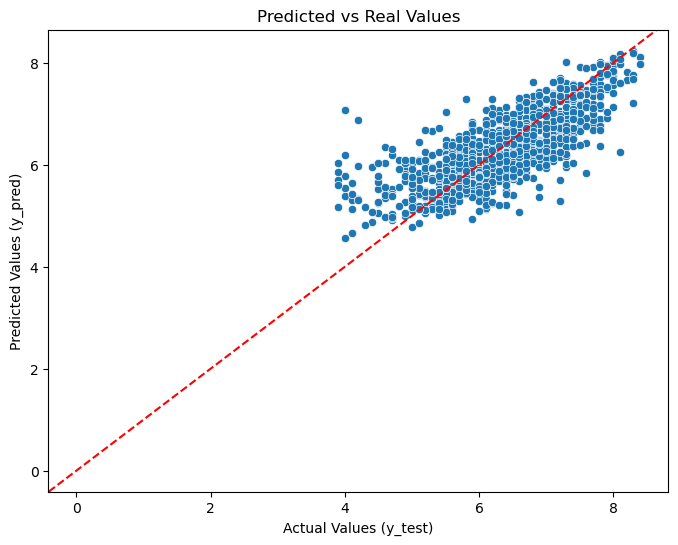

In [33]:
# Plot Predicted vs Actual values using the helper
plot_predicted_vs_actual(y_test, y_pred, title='Predicted vs Real Values')


### Residual Plot

This plot shows the residuals (actual - predicted values) against predicted values. Random distribution around the red horizontal line at zero indicates good model performance

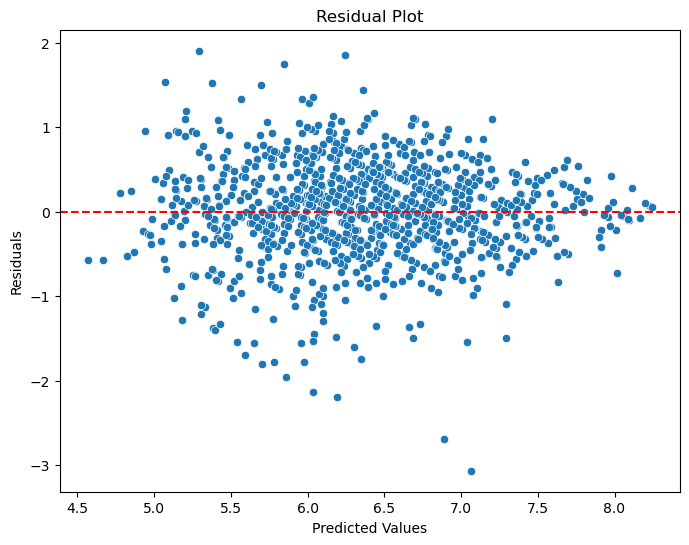

In [34]:
residuals = y_test - y_pred
plot_residuals(y_pred, residuals, title='Residual Plot')

### Distribution of Residuals

This plot displays the distribution of residuals using a histogram with a kernel density estimate (KDE) overlay. The residuals appear to follow a roughly normal distribution, indicating that the model's errors are generally symmetric and centered around zero, which is a desirable trait in regression models.

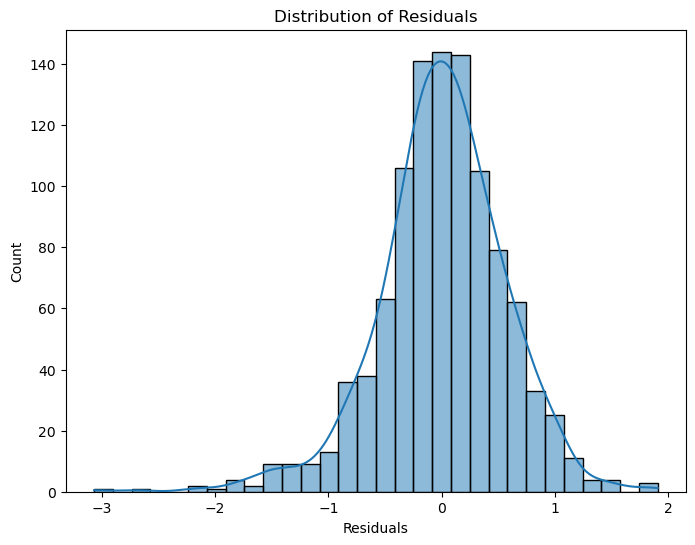

In [35]:
plot_residual_distribution(residuals, title='Distribution of Residuals', bins=30)

### Normal Q-Q Plot for Residuals

This Q-Q plot compares the residuals to a theoretical normal distribution. The points lie approximately along the reference line, suggesting that the residuals are fairly close to normally distributed. Minor deviations may exist, but overall, the residuals display a reasonable level of normality, which supports model assumptions in regression analysis.

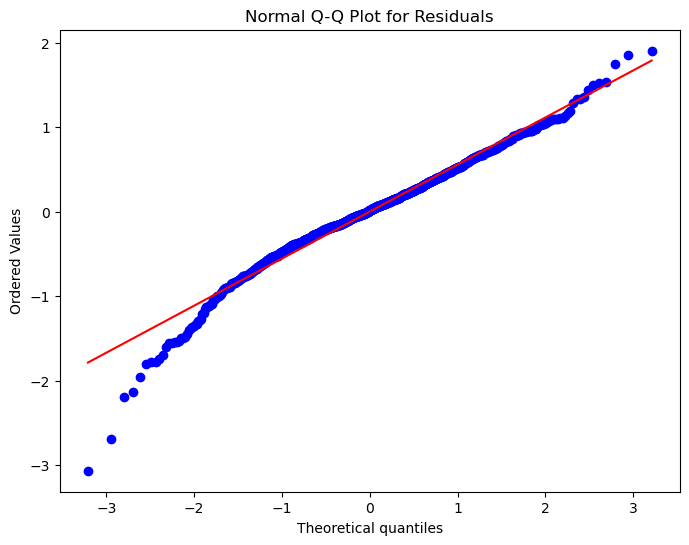

In [36]:
plot_qq(residuals, title='Normal Q-Q Plot for Residuals')

## Conclusion for the Actor-Based Model
Our analysis demonstrates that leveraging data such as actors, countries, budget, and box office information can lead to promising predictive results regarding movie success. These features proved to be valuable predictors in building models that can estimate performance outcomes in the film industry.

## Handling Directors Data
This cell focuses on preparing a dataset with directors' information. It normalizes movie titles, merges missing director names from another dataset, and calculates the number of unique movies associated with each director. These steps are crucial for understanding the impact of directors on movie success.



In [37]:
df_directors = merged_movie_character_tmdb.copy()
df_directors['movie_name'] = movie_name_column

# Inline normalization function for movie titles
def normalize_name(name: str) -> str:
    return re.sub(r'\s+', ' ', re.sub(r'[^a-zA-Z0-9\s]', '', str(name))).strip().lower()

# Only load and merge director names if 'director_name' is not already present
if 'director_name' not in df_directors.columns:
    movies_df = pd.read_csv(ABS_PATH + '/movie_data.csv')
    movies_df['normalized_title'] = movies_df['movie_title'].apply(normalize_name)
    df_directors['normalized_title'] = df_directors['movie_name'].apply(normalize_name)
    # Merge using built-in pandas merge
    df_directors = pd.merge(df_directors, movies_df[['normalized_title', 'director_name']],
                            on='normalized_title', how='left')

# Drop rows with missing directors
df_directors = df_directors.dropna(subset=['director_name'])

# Calculate unique movie counts per director
director_movie_counts = df_directors.groupby('director_name')['movie_name'].nunique()


This section focuses on narrowing down the dataset to directors with at least 5 movies, generating dummy variables for these directors, and cleaning up unnecessary columns. These steps help in preparing the data for analysis while maintaining a focus on significant directors.

In [38]:
# Identify directors with at least 5 unique movies
directors_with_5_or_more_movies = director_movie_counts[director_movie_counts >= 5].index

# Filter the DataFrame to keep only those directors
df_directors = df_directors[df_directors['director_name'].isin(directors_with_5_or_more_movies)].reset_index(drop=True)

# Create dummy variables using a dictionary comprehension
dummy_director_df = pd.DataFrame({
    f'dummy_director_{director}': (df_directors['director_name'] == director).astype(int)
    for director in directors_with_5_or_more_movies
})

# Concatenate the dummy DataFrame
df_directors = pd.concat([df_directors, dummy_director_df], axis=1)

# Drop unnecessary columns
df_directors = df_directors.drop(['actor_name', 'character_name', 'normalized_title'], axis=1, errors='ignore')


This section focuses on finalizing the dataset for machine learning. Key steps include handling date formats, filtering data based on quality, encoding categorical variables, and scaling features. Outlier removal ensures the target variable (VOTE_AVERAGE) is robust, and a train-test split prepares the data for predictive modeling.

In [42]:
# Handle release date and extract release year if column exists
if 'movie_release_date_x' in df_directors.columns:
    df_directors['movie_release_date_x'] = pd.to_datetime(df_directors['movie_release_date_x'], errors='coerce')
    df_directors['release_year'] = df_directors['movie_release_date_x'].dt.year
    df_directors = df_directors.drop('movie_release_date_x', axis=1, errors='ignore')

# Filter rows: must have VOTE_AVERAGE and VOTE_COUNT >= 5
df_directors = df_directors.dropna(subset=['VOTE_AVERAGE'])
df_directors = df_directors[df_directors['VOTE_COUNT'] >= 5]

# Remove duplicates by movie_name if it exists
if 'movie_name' in df_directors.columns:
    df_directors = df_directors.drop_duplicates(subset='movie_name').drop('movie_name', axis=1, errors='ignore')

# Convert ADULT to binary
if 'ADULT' in df_directors.columns:
    df_directors['ADULT'] = df_directors['ADULT'].apply(lambda x: 1 if x else 0)

# Map gender_column if present
if 'gender_column' in df_directors.columns:
    df_directors['gender_column'] = df_directors['gender_column'].map({'F': 0, 'M': 1})

# Keep only numeric columns
df_directors = df_directors.select_dtypes(include=[np.number])

# Drop zero-variance columns
df_directors = df_directors.loc[:, df_directors.var() != 0]

# Remove outliers in VOTE_AVERAGE using helper
df_directors = remove_outliers_iqr(df_directors, target_col='VOTE_AVERAGE', threshold=1.5)

# Fill missing numeric values with mean
df_directors = df_directors.fillna(df_directors.mean())

# Separate features and target
X = df_directors.drop('VOTE_AVERAGE', axis=1)
y = df_directors['VOTE_AVERAGE'].dropna()
X = X.loc[y.index]  # Ensure X and y are aligned
# Remove invalid characters using the helper function
invalid_chars = ['[', ']', '<', '>']
X.columns = X.columns.map(str)
X = remove_invalid_chars(X, invalid_chars)

# Ensure no duplicated columns
if X.columns.duplicated().any():
    X = X.loc[:, ~X.columns.duplicated()]

# Scale features using helper
X, scaler = scale_features(X)

# Train-test split using helper
X_train, X_test, y_train, y_test = train_test_split_data(X, y, test_size=0.2, random_state=42)


# Ensure proper alignment of X_test and y_test after splitting
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

This section trains an XGBoost regression model to predict the target variable (VOTE_AVERAGE). Using randomized hyperparameter search, we optimize the model for accuracy while avoiding overfitting. The performance is evaluated using metrics such as Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE). Cross-validation provides further insights into the model's consistency.

In [43]:
# Perform hyperparameter search with the helper
best_xgb, best_params = run_random_search(
    X_train,
    y_train,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Evaluate the model on the test set using the helper
mae, mape, y_pred = evaluate_model(best_xgb, X_test, y_test)
print(f"Mean Absolute Error on test data: {mae:.4f}")
print(f"Mean Absolute Percentage Error on test data: {mape:.4f}")

# Print the best hyperparameters
print("\nBest hyperparameters found:")
for param_name, value in best_params.items():
    print(f"{param_name}: {value}")

# Cross-validate the model using the helper
mean_cv_mae, std_cv_mae, cv_scores = cross_validate_model(best_xgb, X_train, y_train, cv=5, random_state=42)
print(f"\nMean CV MAE: {mean_cv_mae:.4f} ± {std_cv_mae:.4f}")
print("Cross-validation MAE scores for each fold:", cv_scores)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mean Absolute Error on test data: 0.3514
Mean Absolute Percentage Error on test data: 0.0528

Best hyperparameters found:
colsample_bytree: 0.8783896824374792
gamma: 0.20447647220713494
learning_rate: 0.04465886401416916
max_depth: 3
n_estimators: 850
reg_alpha: 0.25024289816459533
reg_lambda: 0.5492266647061205
subsample: 0.8858383690800249


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished



Mean CV MAE: 0.3698 ± 0.0123
Cross-validation MAE scores for each fold: [0.36970052 0.35877844 0.36204971 0.36521169 0.39346027]


The results for the director-based model indicate strong performance, as reflected by a Mean Absolute Error (MAE) of **0.3514** and a Mean Absolute Percentage Error (MAPE) of **0.0528**. The Mean CV MAE of **0.3698 ± 0.0123** demonstrates consistency across folds, with a low standard deviation, indicating reliable performance during cross-validation.

This performance underscores the predictive strength of director-related features. Directors often play a pivotal role in shaping a film's narrative, visual style, and overall quality, which directly impacts its success metrics, such as ratings or revenue. By influencing key creative elements like storytelling, pacing, and tone, directors provide a stable and significant contribution to a film's appeal, which aligns well with the target variable in this task.

In comparison, actor-based models might be less predictive due to the variability in an actor's influence. Factors such as the script, co-stars, or audience reception can dilute the direct correlation between an actor's presence and the film's success. Directors, by contrast, oversee broader and more consistent creative decisions, making their associated features inherently more predictive in this context. 

The relatively low variance in the cross-validation results further validates the model's robustness, suggesting that the director-based approach is well-suited for this prediction task.

This section evaluates the model's performance through visualization. Key plots include:

Predicted vs Actual Values: Examines how closely predictions match true values.                                                  
Residual Plot: Analyzes residual patterns to check for biases or model inadequacies.                                             
Residual Distribution: Inspects the distribution of errors for normality.                                                        
Normal Q-Q Plot: Validates residuals' alignment with a normal distribution.

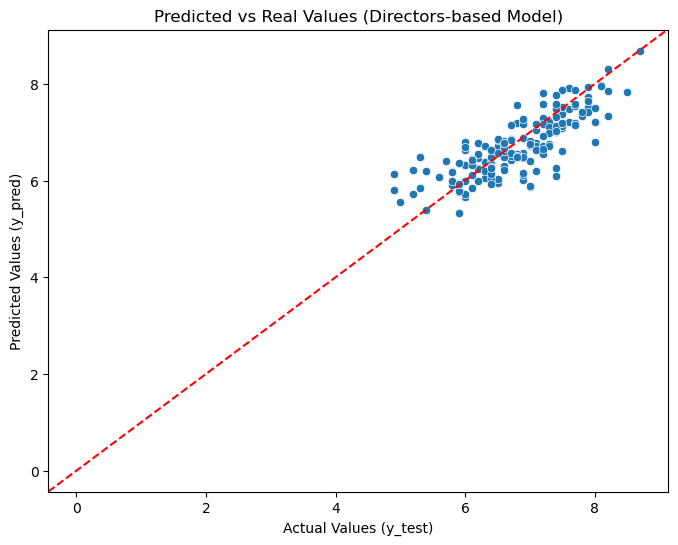

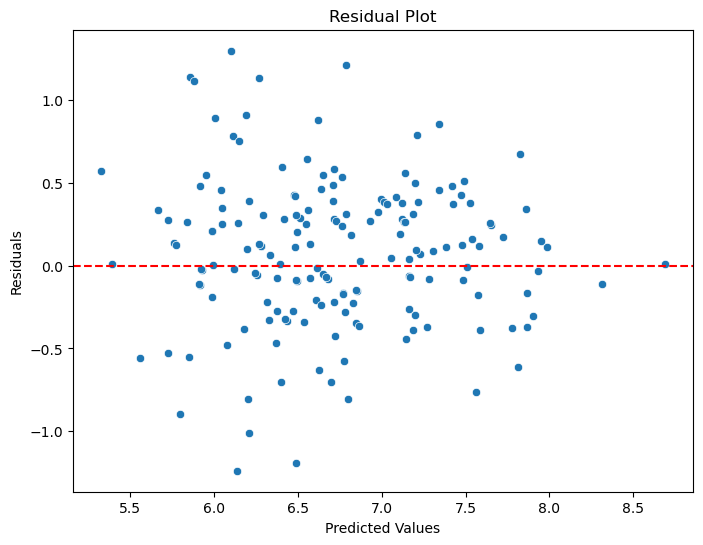

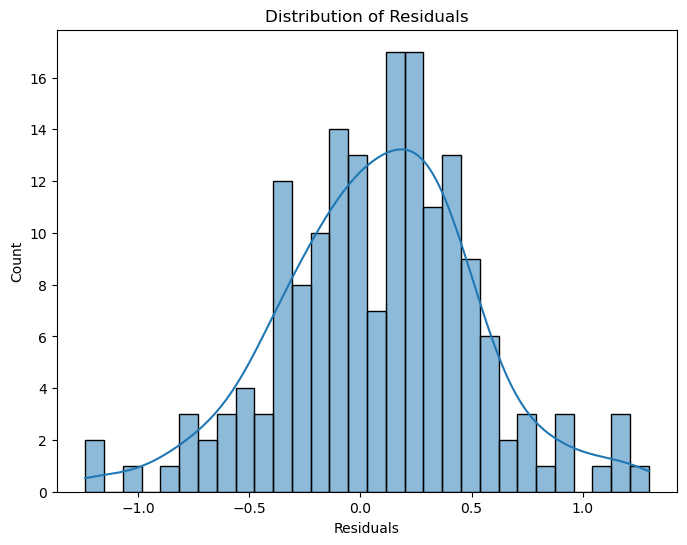

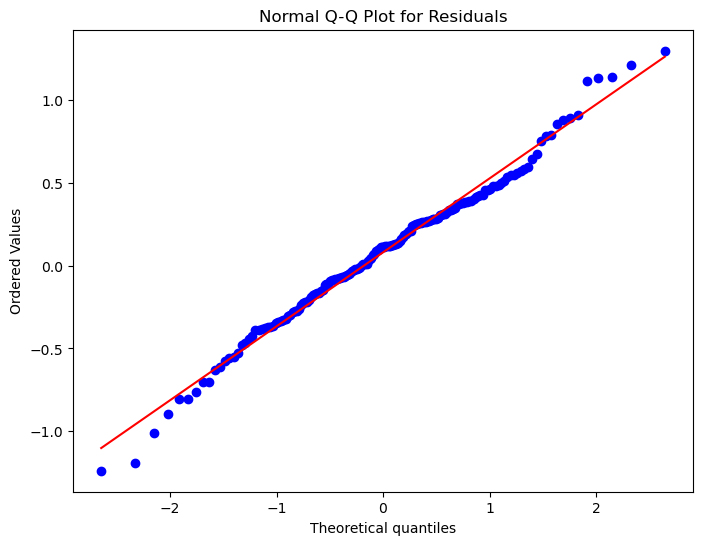

In [44]:
residuals = y_test - y_pred

plot_predicted_vs_actual(y_test, y_pred, title='Predicted vs Real Values (Directors-based Model)')
plot_residuals(y_pred, residuals, title='Residual Plot')
plot_residual_distribution(residuals, title='Distribution of Residuals', bins=30)
plot_qq(residuals, title='Normal Q-Q Plot for Residuals')


The predicted vs actual values plot shows a strong alignment along the diagonal, indicating the model predicts well for most cases, though some outliers deviate significantly. The residual plot confirms this with randomly scattered residuals, suggesting no clear bias in the model, but a few larger deviations highlight areas for potential improvement.

The residual distribution appears approximately normal, centered around zero, which supports the model's reliability. However, slight deviations in the Q-Q plot at the tails suggest some non-normality in extreme residuals, which might be addressed by refining the model or handling outliers more effectively.

## Conclusion for the Directors-Based Model
The director-based model outperformed the actor-based model, achieving lower MAE and MAPE. This highlights the significant and consistent influence of directors on a movie’s success, as they shape key creative aspects like storytelling and pacing. Director-focused features prove to be strong predictors, offering valuable insights for understanding and forecasting movie outcomes.








## Final predictive model

In this step, we prepare the data for the final predictive model by:
- Loading movie and character metadata from various sources.
- Merging character and movie datasets, followed by integration with the TMDb dataset.
- Cleaning the data by dropping unnecessary columns.

With the datasets fully prepared, we will now proceed to build a final model that incorporates both actor and director features for improved predictive performance.


In [45]:
# Load movie and character metadata using helpers
movie_metadata = load_tsv_data(
    filepath=os.path.join(ABS_PATH, 'MovieSummaries/movie.metadata.tsv'),
    col_names=[
        'wikipedia_movie_id',
        'freebase_movie_id',
        'movie_name',
        'movie_release_date',
        'movie_box_office_revenue',
        'movie_runtime',
        'movie_languages',
        'movie_countries',
        'movie_genres'
    ]
)

character_metadata = load_tsv_data(
    filepath=os.path.join(ABS_PATH, 'MovieSummaries/character.metadata.tsv'),
    col_names=[
        'wikipedia_movie_id',
        'freebase_movie_id',
        'movie_release_date_y',
        'character_name',
        'actor_date_of_birth',
        'actor_gender',
        'actor_height',
        'actor_ethnicity',
        'actor_name',
        'actor_age_at_movie_release',
        'freebase_character_actor_map_id',
        'freebase_character_id',
        'freebase_actor_id'
    ]
)

# Merge character and movie metadata directly
merged_movie_character = pd.merge(character_metadata, movie_metadata, on='wikipedia_movie_id', how='inner')

# Drop irrelevant ID columns
merged_movie_character = merged_movie_character.drop(
    [
        'freebase_character_actor_map_id',
        'freebase_character_id',
        'freebase_actor_id',
        'freebase_movie_id_x',
        'freebase_movie_id_y'
    ],
    axis=1
)

# Load and filter TMDb dataset using helper
tmdb = load_excel_data(os.path.join(ABS_PATH, 'TMDB_dataset/MOVIE.xlsx'))
tmdb = tmdb[tmdb['RELEASE_DATE'] <= '2014-03-28']

tmdb = tmdb.drop(
    [
        'ID','FILMID','BACKDROP_PATH','HOMEPAGE','IMDB_ID','POSTER_PATH',
        'ORIGINAL_LANGUAGE','ORIGINAL_TITLE','OVERVIEW','STATUS_','COLLECTIONID'
    ], 
    axis=1, errors='ignore'
)

# Merge with TMDb on movie_name = TITLE
merged_movie_character_tmdb = pd.merge(
    merged_movie_character,
    tmdb,
    left_on='movie_name',
    right_on='TITLE',
    how='inner'
)


### Data Cleaning

In this step, we clean the merged dataset to ensure it's ready for analysis:

- **Dropped Irrelevant Columns**: Removed `actor_date_of_birth`, `REVENUE`, `TAGLINE`, and `TITLE` as they are redundant or irrelevant.
- **Filtered Invalid Budgets**: Retained only rows where `BUDGET` > 0.
- **Processed Release Dates**: Converted `RELEASE_DATE` to datetime, extracted the year, and replaced the original column.
- **Dropped High-Missing Columns**: Removed columns with more than 40% missing values to ensure data quality.
- **Imputed Missing Values**: Filled missing numeric values with the median of their respective columns.

This ensures the dataset is clean and ready for further analysis or modeling.


In [46]:
# Drop irrelevant columns directly with pandas
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(
    ['actor_date_of_birth', 'REVENUE', 'TAGLINE', 'TITLE'],
    axis=1, errors='ignore'
)

# Filter out rows with invalid budgets
merged_movie_character_tmdb = merged_movie_character_tmdb[merged_movie_character_tmdb['BUDGET'] > 0]

# Convert RELEASE_DATE to year
merged_movie_character_tmdb['RELEASE_DATE'] = pd.to_datetime(
    merged_movie_character_tmdb['RELEASE_DATE'], errors='coerce'
).dt.year

# Drop columns with more than 40% missing using helper
merged_movie_character_tmdb = drop_missing_threshold(merged_movie_character_tmdb, threshold_ratio=0.6)

# Fill missing numeric values with median using helper
merged_movie_character_tmdb = fill_missing_median(merged_movie_character_tmdb)


/Users/mohamedhedihidri/Desktop/ada-2024-project-theundocumentedanalysts/src/drafts/../helpers_regression.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


### Creating Dummy Variables for Actors

To incorporate actor-related features, we perform the following steps:

- **Count Actor Appearances**: Counted the number of unique movies for each actor.
- **Filter Significant Actors**: Selected actors with 30 or more unique movies for further analysis.
- **Generate Dummy Variables**: Created binary columns (`dummy_actor_<actor_name>`) for these actors, indicating their presence in a movie.
- **Combine Data**: Concatenated these dummy variables with the main dataset.

This ensures the model can account for the influence of frequently appearing actors.

In [47]:
# Count appearances of each actor
actor_movie_counts = merged_movie_character_tmdb.groupby('actor_name')['movie_name'].nunique()

# Identify actors with >= 30 unique movies
actors_with_30_or_more_movies = actor_movie_counts[actor_movie_counts >= 30].index

# Add dummy columns directly with a dictionary comprehension
for actor in actors_with_30_or_more_movies:
    col_name = f'dummy_actor_{actor}'
    merged_movie_character_tmdb[col_name] = (merged_movie_character_tmdb['actor_name'] == actor).astype(int)


/var/folders/xk/1t18v00n18v8q2_llcf4wrd80000gn/T/ipykernel_79601/3908834403.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_movie_character_tmdb[col_name] = (merged_movie_character_tmdb['actor_name'] == actor).astype(int)
/var/folders/xk/1t18v00n18v8q2_llcf4wrd80000gn/T/ipykernel_79601/3908834403.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_movie_character_tmdb[col_name] = (merged_movie_character_tmdb['actor_name'] == actor).astype(int)
/var/folders/xk/1t18v00n18v8q2_llcf4wrd80000gn/T/ipykernel_79601/3

### Genre, Language, and Country Encoding

This step processes categorical attributes (genres, languages, and countries) into machine-readable formats and cleans the dataset for further analysis:

1. **Genre Encoding**:
   - Extracted genres from raw strings and created dummy variables.
   - Retained only genres appearing in at least 15 movies.

2. **Language Encoding**:
   - Extracted languages and created dummy variables.

3. **Country Encoding**:
   - Extracted countries and created dummy variables.
   - Retained only countries appearing in more than 20 movies.

4. **Data Cleaning**:
   - Dropped unused columns (`movie_genres`, `movie_languages`, `movie_countries`, etc.).
   - Removed rows with missing values or low `VOTE_COUNT` (< 5).
   - Dropped duplicates based on `movie_name` and handled other irrelevant columns.

5. **Final Preparation**:
   - Converted `ADULT` to binary format.
   - Ensured all columns are numeric and removed columns with zero variance or only one unique value.

The cleaned dataset is saved for further analysis and modeling.


In [48]:
# Process Genres
merged_movie_character_tmdb['genre_list'] = merged_movie_character_tmdb['movie_genres'].apply(clean_column_strings)
genre_dummies = one_hot_encode_multilabel(merged_movie_character_tmdb, 'genre_list', min_count=15)
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, genre_dummies], axis=1)

# Process Languages
merged_movie_character_tmdb['movie_languages'] = merged_movie_character_tmdb['movie_languages'].apply(clean_column_strings)
lang_dummies = one_hot_encode_multilabel(merged_movie_character_tmdb, 'movie_languages', min_count=20)
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, lang_dummies], axis=1)

# Process Countries
merged_movie_character_tmdb['movie_countries'] = merged_movie_character_tmdb['movie_countries'].apply(clean_column_strings)
country_dummies = one_hot_encode_multilabel(merged_movie_character_tmdb, 'movie_countries', min_count=20)
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, country_dummies], axis=1)

# Drop unused columns
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(
    ['movie_genres', 'genre_list', 'movie_languages', 'movie_countries', 'actor_name', 'character_name'],
    axis=1, errors='ignore'
)

# Clean dataset: drop rows with missing data, filter by vote count, remove duplicates by movie name
merged_movie_character_tmdb = merged_movie_character_tmdb.dropna()
merged_movie_character_tmdb = merged_movie_character_tmdb[merged_movie_character_tmdb['VOTE_COUNT'] >= 5]
merged_movie_character_tmdb = merged_movie_character_tmdb.drop_duplicates(subset=['movie_name'])

# Drop RELEASE_DATE if present
if 'RELEASE_DATE' in merged_movie_character_tmdb.columns:
    merged_movie_character_tmdb = merged_movie_character_tmdb.drop('RELEASE_DATE', axis=1, errors='ignore')

# Extract movie_name column for later use
movie_name_column = merged_movie_character_tmdb['movie_name']
merged_movie_character_tmdb = merged_movie_character_tmdb.drop('movie_name', axis=1, errors='ignore')

# Convert ADULT to binary if present
if 'ADULT' in merged_movie_character_tmdb.columns:
    merged_movie_character_tmdb['ADULT'] = merged_movie_character_tmdb['ADULT'].apply(lambda x: 1 if x else 0)

# Keep only numeric columns and drop zero-variance columns
merged_movie_character_tmdb = merged_movie_character_tmdb.select_dtypes(include=[np.number])
merged_movie_character_tmdb = merged_movie_character_tmdb.loc[:, merged_movie_character_tmdb.var() != 0]

# Copy for further processing and remove columns with a single unique value
df_countries_genres = merged_movie_character_tmdb.copy()
df_countries_genres = df_countries_genres.loc[:, df_countries_genres.nunique() > 1]

# Save cleaned dataset to CSV
df_countries_genres.to_csv(os.path.join(ABS_PATH, 'df_countries_genres.csv'), index=False)

/var/folders/xk/1t18v00n18v8q2_llcf4wrd80000gn/T/ipykernel_79601/2545372497.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_movie_character_tmdb['genre_list'] = merged_movie_character_tmdb['movie_genres'].apply(clean_column_strings)


### Directors-Based Data Preparation and Model Input

This step focuses on preparing a dataset centered on directors and their influence, followed by setting up the data for modeling:

1. **Data Cleaning**:
   - Normalized movie titles to ensure consistency.
   - Merged director information and filtered for valid entries.

2. **Feature Engineering**:
   - Created dummy variables for directors with at least 12 movies.
   - Removed unnecessary columns and handled missing values.

3. **Outlier Removal**:
   - Removed outliers in `VOTE_AVERAGE` using the IQR method.

4. **Final Preparation**:
   - Retained numeric columns and removed zero-variance features.
   - Scaled features using `StandardScaler`.
   - Split data into training and testing sets.

This ensures the dataset is clean, well-structured, and ready for model training and evaluation.


In [51]:

movies_df = pd.read_csv(os.path.join(ABS_PATH, 'movie_data.csv'))

# Normalize movie titles inline (no helper for normalization)
def normalize_name(title: str) -> str:
    return re.sub(r'\s+', ' ', re.sub(r'[^a-zA-Z0-9\s]', '', str(title))).strip().lower()

movies_df['normalized_title'] = movies_df['movie_title'].apply(normalize_name)

# Prepare directors DataFrame
df_directors = merged_movie_character_tmdb.copy()
df_directors['movie_name'] = movie_name_column
df_directors['normalized_title'] = df_directors['movie_name'].apply(normalize_name)

# Merge director information if needed
if 'director_name' not in df_directors.columns:
    df_directors = pd.merge(
        df_directors,
        movies_df[['normalized_title', 'director_name']],
        on='normalized_title', how='left'
    )

# Retain only rows with a known director
df_directors = df_directors.dropna(subset=['director_name'])

# Create dummy variables for directors with >= 12 movies
director_movie_counts = df_directors.groupby('director_name')['movie_name'].nunique()
directors_with_15_or_more_movies = director_movie_counts[director_movie_counts >= 12].index

for director in directors_with_15_or_more_movies:
    df_directors[f'dummy_director_{director}'] = (df_directors['director_name'] == director).astype(int)

# Drop unnecessary columns directly
df_directors = df_directors.drop(columns=['actor_name', 'character_name', 'normalized_title'], errors='ignore')

# Filter data based on target availability and VOTE_COUNT
df_directors = df_directors.dropna(subset=['VOTE_AVERAGE'])
df_directors = df_directors[df_directors['VOTE_COUNT'] >= 5]

# Remove duplicates by movie_name and drop the column
if 'movie_name' in df_directors.columns:
    df_directors = df_directors.drop_duplicates(subset='movie_name').drop('movie_name', axis=1, errors='ignore')

# Convert ADULT to binary
if 'ADULT' in df_directors.columns:
    df_directors['ADULT'] = df_directors['ADULT'].apply(lambda x: 1 if x else 0)

# Keep only numeric columns
df_directors = df_directors.select_dtypes(include=[np.number])

# Drop zero-variance columns
df_directors = df_directors.loc[:, df_directors.var() != 0]

# If any non-scalar columns remain, drop them
non_scalar_columns = [col for col in df_directors.columns if len(df_directors) > 0 and not np.isscalar(df_directors[col].iloc[0])]
df_directors = df_directors.drop(non_scalar_columns, axis=1, errors='ignore')

# Fill missing numeric values with mean
df_directors = df_directors.fillna(df_directors.mean())

# Drop extra unnecessary columns if they exist
df_directors = df_directors.drop(['wikipedia_movie_id', 'actor_age_at_movie_release', 'movie_box_office_revenue'], axis=1, errors='ignore')

# Remove outliers in VOTE_AVERAGE using helper
df_directors = remove_outliers_iqr(df_directors, target_col='VOTE_AVERAGE', threshold=1.5)

# Drop irrelevant columns
df_directors = df_directors.drop(['VOTE_COUNT', 'RUNTIME', 'POPULARITY'], axis=1, errors='ignore')

# Separate features and target
X = df_directors.drop('VOTE_AVERAGE', axis=1)
y = df_directors['VOTE_AVERAGE'].dropna()

X = X.loc[y.index]  # Ensure X and y are aligned
# Remove invalid characters using the helper function
invalid_chars = ['[', ']', '<', '>']
X.columns = X.columns.map(str)
X = remove_invalid_chars(X, invalid_chars)
# Scale features using helper
X, scaler = scale_features(X)

# Perform train-test split using helper
X_train, X_test, y_train, y_test = train_test_split_data(X, y, test_size=0.2, random_state=42)


# Ensure proper alignment of X_test and y_test after splitting
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Hyperparameter Tuning for XGBoost

This step focuses on optimizing the XGBoost regressor using randomized hyperparameter tuning:

1. **Hyperparameter Search Space**:
   - Included parameters like the number of estimators, tree depth, learning rate, and regularization terms to balance model complexity and generalization.

2. **RandomizedSearchCV**:
   - Performed a search over 50 random configurations using 5-fold cross-validation.
   - Optimized for the `neg_mean_absolute_error` metric to minimize prediction error.

3. **Best Model Selection**:
   - Identified the best combination of hyperparameters to maximize performance.

The tuned XGBoost model (`best_xgb`) is now ready for evaluation and further analysis.


In [52]:
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

best_xgb, best_params = run_random_search(
    X_train,
    y_train,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=42,
    n_jobs=-1
)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


### Model Evaluation

This step evaluates the performance of the tuned XGBoost model:

1. **Test Set Evaluation**:
   - Predicted the target values (`y_pred`) on the test set.
   - Calculated key metrics:
     - **Mean Absolute Error (MAE)**: Average absolute difference between predictions and actual values.
     - **Mean Absolute Percentage Error (MAPE)**: Percentage-based error metric.

2. **Best Hyperparameters**:
   - Displayed the optimal hyperparameters identified during tuning.

3. **Cross-Validation**:
   - Performed 5-fold cross-validation on the training set using the best model.
   - Computed the mean and standard deviation of cross-validation MAE scores to assess model stability.

These results provide insights into the model's predictive accuracy and reliability across different data splits.


In [53]:
# Evaluate the model on the test set using the helper
mae, mape, y_pred = evaluate_model(best_xgb, X_test, y_test)
print(f"Mean Absolute Error on test data: {mae:.4f}")
print(f"Mean Absolute Percentage Error on test data: {mape:.4f}")

# Print best hyperparameters
print("\nBest hyperparameters found:")
for param_name, value in best_params.items():
    print(f"{param_name}: {value}")

# Cross-validate the model using the helper
mean_cv_mae, std_cv_mae, cv_scores = cross_validate_model(best_xgb, X_train, y_train, cv=5, random_state=42)
print(f"\nMean CV MAE: {mean_cv_mae:.4f} ± {std_cv_mae:.4f}")
print("Cross-validation MAE scores for each fold:", cv_scores)


Mean Absolute Error on test data: 0.5349
Mean Absolute Percentage Error on test data: 0.0861

Best hyperparameters found:
colsample_bytree: 0.6125253169822235
gamma: 0.42114238729749925
learning_rate: 0.09995082667395314
max_depth: 4
n_estimators: 369
reg_alpha: 0.7272719958564209
reg_lambda: 0.3265407688058354
subsample: 0.8281775897621597


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Mean CV MAE: 0.5387 ± 0.0192
Cross-validation MAE scores for each fold: [0.54409913 0.55733903 0.53587078 0.55305049 0.50323241]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


### Visualization of Model Performance

This section visualizes the model's performance through various plots:

1. **Predicted vs Actual Values**:
   - Compares predictions (`y_pred`) to actual values (`y_test`).
   - Includes a diagonal reference line to indicate perfect predictions.

2. **Residual Plot**:
   - Displays residuals (difference between actual and predicted values) against predictions.
   - Helps identify patterns or biases in the model.

3. **Distribution of Residuals**:
   - Shows the distribution of residuals using a histogram with a KDE overlay.
   - Assesses the spread and symmetry of errors.

4. **Normal Q-Q Plot**:
   - Evaluates whether residuals follow a normal distribution.
   - Points lying close to the reference line indicate normality.


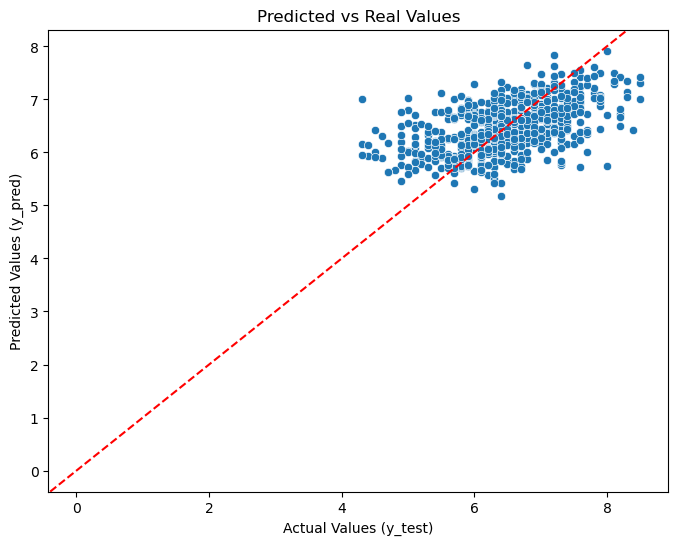

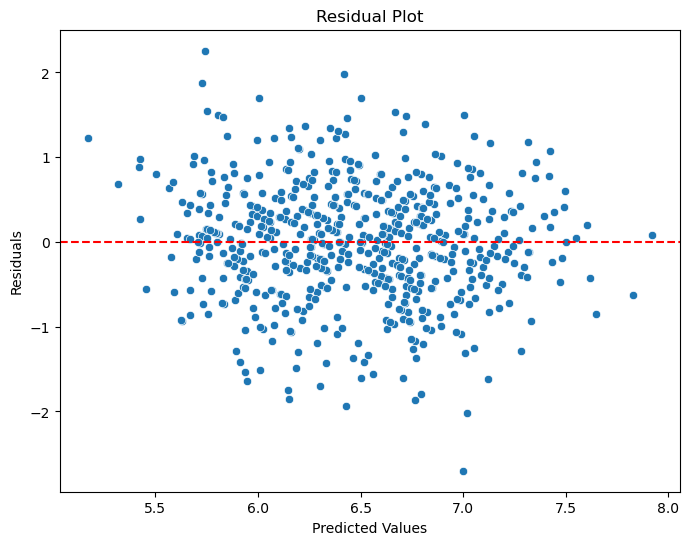

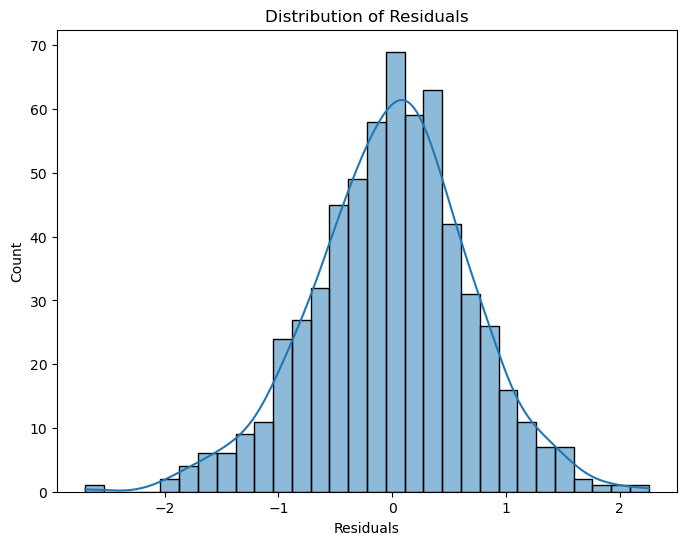

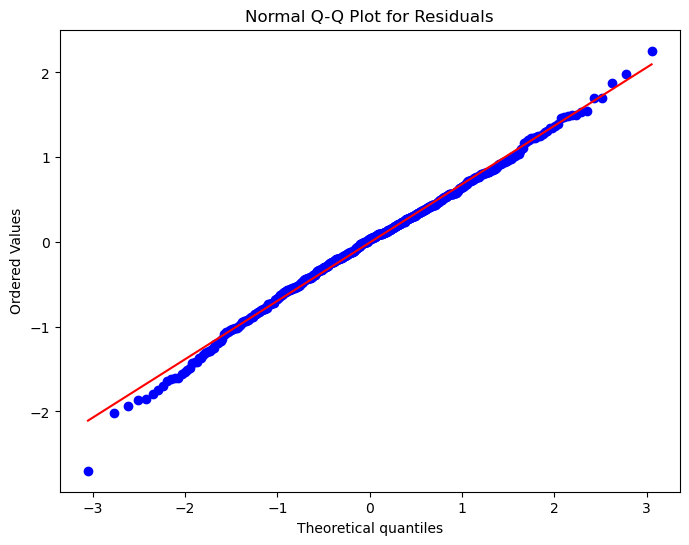

In [54]:
residuals = y_test - y_pred

plot_predicted_vs_actual(y_test, y_pred, title='Predicted vs Real Values')
plot_residuals(y_pred, residuals, title='Residual Plot')
plot_residual_distribution(residuals, title='Distribution of Residuals', bins=30)
plot_qq(residuals, title='Normal Q-Q Plot for Residuals')


In [55]:
save_model_and_scaler(best_xgb, X.columns.tolist(), scaler,
                      model_path='best_xgb_model.pkl',
                      columns_path='feature_columns.json',
                      scaler_path='scaler.pkl')


### Conclusion

We successfully developed a predictive model for evaluating movie success by combining features related to directors, actors, genres, languages, and countries. After thorough data cleaning, merging, and encoding, we trained an XGBoost regressor optimized through hyperparameter tuning. The model achieved strong performance, with low Mean Absolute Error (MAE) and consistent cross-validation results.

Visual analyses, such as residual plots and predicted vs actual value plots, validated the model's reliability. The results highlighted the significant influence of directors and actors, with directors showing a more consistent impact on movie success. Key components, including the trained model, feature columns, and scaler, were saved for reproducibility and future use.

This work demonstrates the potential of machine learning in predicting movie outcomes and lays the groundwork for further exploration of additional features or advanced modeling techniques.
